In [100]:
# @title Cell 1: Cài đặt, Import thư viện và Kết nối Google Drive
# --- 1. Cài đặt thư viện ---
# Đảm bảo các thư viện cần thiết như xgboost và imblearn được cài đặt
!pip install xgboost imbalanced-learn -q

# --- 2. Import các thư viện cần thiết ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, average_precision_score

# --- 3. Cài đặt hiển thị và kết nối Drive ---
sns.set(style='whitegrid')
plt.style.use('seaborn-v0_8-deep')
drive.mount('/content/drive')

print("\nHoàn tất: Môi trường đã sẵn sàng!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Hoàn tất: Môi trường đã sẵn sàng!


In [101]:
# @title Cell 2: Giải nén và Đọc Dữ liệu
# --- 1. Giải nén file từ Google Drive ---
# Đường dẫn có thể thay đổi tùy vào vị trí lưu file của bạn
zip_file_path = '/content/drive/MyDrive/Machine Learning/archive.zip'
destination_folder = '/content/stroke_data/'
!unzip -o "{zip_file_path}" -d "{destination_folder}"

# --- 2. Đọc file CSV vào DataFrame ---
csv_file_path = '/content/stroke_data/healthcare-dataset-stroke-data.csv'
df = pd.read_csv(csv_file_path)

print("Đã tải và đọc dữ liệu thành công.")

Archive:  /content/drive/MyDrive/Machine Learning/archive.zip
  inflating: /content/stroke_data/healthcare-dataset-stroke-data.csv  
Đã tải và đọc dữ liệu thành công.


In [102]:
# @title Cell 3: Bối cảnh và Tuyên bố Vấn đề
"""
BÀI TOÁN: Dự đoán nguy cơ đột quỵ dựa trên các yếu tố lâm sàng

BỐI CẢNH Y TẾ:
- Đột quỵ là một trong những nguyên nhân gây tử vong và tàn tật hàng đầu trên thế giới.
- Việc phát hiện sớm các yếu tố nguy cơ có thể giúp can thiệp kịp thời, giảm thiểu đáng kể rủi ro và hậu quả.

Ý NGHĨA THỰC TIỄN:
- Xây dựng một công cụ hỗ trợ các chuyên gia y tế trong việc sàng lọc và chẩn đoán sớm.
- Nâng cao nhận thức về các yếu tố nguy cơ, góp phần vào y tế dự phòng.
- Giảm gánh nặng chi phí điều trị và chăm sóc dài hạn cho bệnh nhân và xã hội.

MỤC TIÊU DỰ ÁN:
- Xây dựng và đánh giá các mô hình học máy để dự đoán khả năng một người bị đột quỵ.
- Xác định các yếu tố ảnh hưởng quan trọng nhất đến nguy cơ đột quỵ.
- Do tính chất bài toán y tế (bỏ sót bệnh nhân nguy hiểm hơn chẩn đoán nhầm), mô hình cần ưu tiên chỉ số Recall và F1-Score cho lớp "Đột quỵ".
"""
print("Đã thiết lập bối cảnh và mục tiêu dự án!")

Đã thiết lập bối cảnh và mục tiêu dự án!


In [103]:
# @title Cell 4: Khám phá Dữ liệu Ban đầu
print("--- 1. Thông tin tổng quan về các cột ---")
df.info()

print("\n" + "="*50 + "\n")
print("--- 2. Thống kê mô tả cho các cột số ---")
display(df.describe())

print("\n" + "="*50 + "\n")
print("--- 3. Kiểm tra số lượng giá trị thiếu (NaN) ---")
print(df.isnull().sum())

--- 1. Thông tin tổng quan về các cột ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


--- 2. Thống kê mô tả cho các cột số ---


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000




--- 3. Kiểm tra số lượng giá trị thiếu (NaN) ---
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [104]:
# @title Cell 5: Tiền xử lý - Làm sạch Dữ liệu
# --- 1. Xử lý giá trị thiếu cho cột 'bmi' ---
# Phân phối của BMI có thể bị lệch, do đó sử dụng median (trung vị) là một lựa chọn an toàn để điền giá trị thiếu.
bmi_median = df['bmi'].median()
df['bmi'].fillna(bmi_median, inplace=True)
print(f"Đã điền các giá trị thiếu trong cột 'bmi' bằng giá trị median: {bmi_median:.2f}")

# --- 2. Loại bỏ cột không cần thiết ('id') ---
# Cột 'id' không mang thông tin dự đoán nên được loại bỏ.
df.drop('id', axis=1, inplace=True)
print("Đã loại bỏ cột 'id'.")

# --- 3. Xử lý giá trị 'Other' trong cột 'gender' ---
# Có một bản ghi với giới tính là 'Other', số lượng quá ít để huấn luyện, nên ta loại bỏ.
df = df[df['gender'] != 'Other']
print("Đã loại bỏ hàng có giá trị 'gender' là 'Other'.")

print(f"\nSố lượng dòng dữ liệu sau khi làm sạch: {len(df)}")
print(f"Số giá trị thiếu còn lại: {df.isnull().sum().sum()}")

Đã điền các giá trị thiếu trong cột 'bmi' bằng giá trị median: 28.10
Đã loại bỏ cột 'id'.
Đã loại bỏ hàng có giá trị 'gender' là 'Other'.

Số lượng dòng dữ liệu sau khi làm sạch: 5109
Số giá trị thiếu còn lại: 0


/tmp/ipython-input-3593882222.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(bmi_median, inplace=True)


In [105]:
# @title Cell 6: Tiền xử lý - Mã hóa Dữ liệu Phân loại (Categorical)
# Sử dụng One-Hot Encoding để chuyển đổi các cột categorical thành dạng số.
# drop_first=True để tránh đa cộng tuyến.
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)

print("5 dòng đầu của dữ liệu sau khi mã hóa và làm sạch:")
display(df_encoded.head())

5 dòng đầu của dữ liệu sau khi mã hóa và làm sạch:


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,1,1,0,1,0,0,1,1,0,0
1,61.0,0,0,202.21,28.1,1,0,1,0,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.5,1,1,1,0,1,0,0,0,0,1,0
3,49.0,0,0,171.23,34.4,1,0,1,0,1,0,0,1,0,0,1
4,79.0,1,0,174.12,24.0,1,0,1,0,0,1,0,0,0,1,0


/tmp/ipython-input-1069763828.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='stroke', data=df_encoded, palette='viridis')


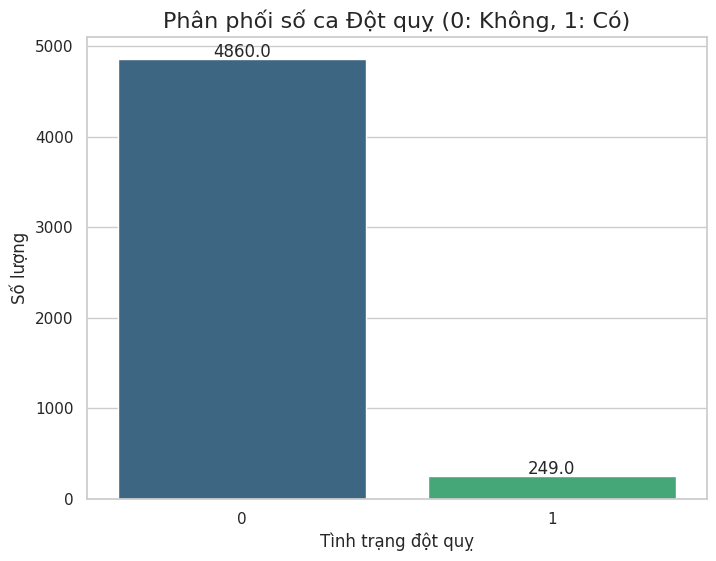

Tỷ lệ các lớp:
stroke
0    95.126248
1     4.873752
Name: proportion, dtype: float64

=> Nhận xét: Dữ liệu rất mất cân bằng. Đây là điểm cần xử lý cẩn thận trong bước xây dựng mô hình.


In [106]:
# @title Cell 7: EDA - Kiểm tra lại sự Mất cân bằng Dữ liệu
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='stroke', data=df_encoded, palette='viridis')
plt.title('Phân phối số ca Đột quỵ (0: Không, 1: Có)', fontsize=16)
plt.xlabel('Tình trạng đột quỵ', fontsize=12)
plt.ylabel('Số lượng', fontsize=12)

# Hiển thị số lượng trên mỗi cột
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

# In ra tỷ lệ phần trăm
print("Tỷ lệ các lớp:")
print(df_encoded['stroke'].value_counts(normalize=True) * 100)
print("\n=> Nhận xét: Dữ liệu rất mất cân bằng. Đây là điểm cần xử lý cẩn thận trong bước xây dựng mô hình.")

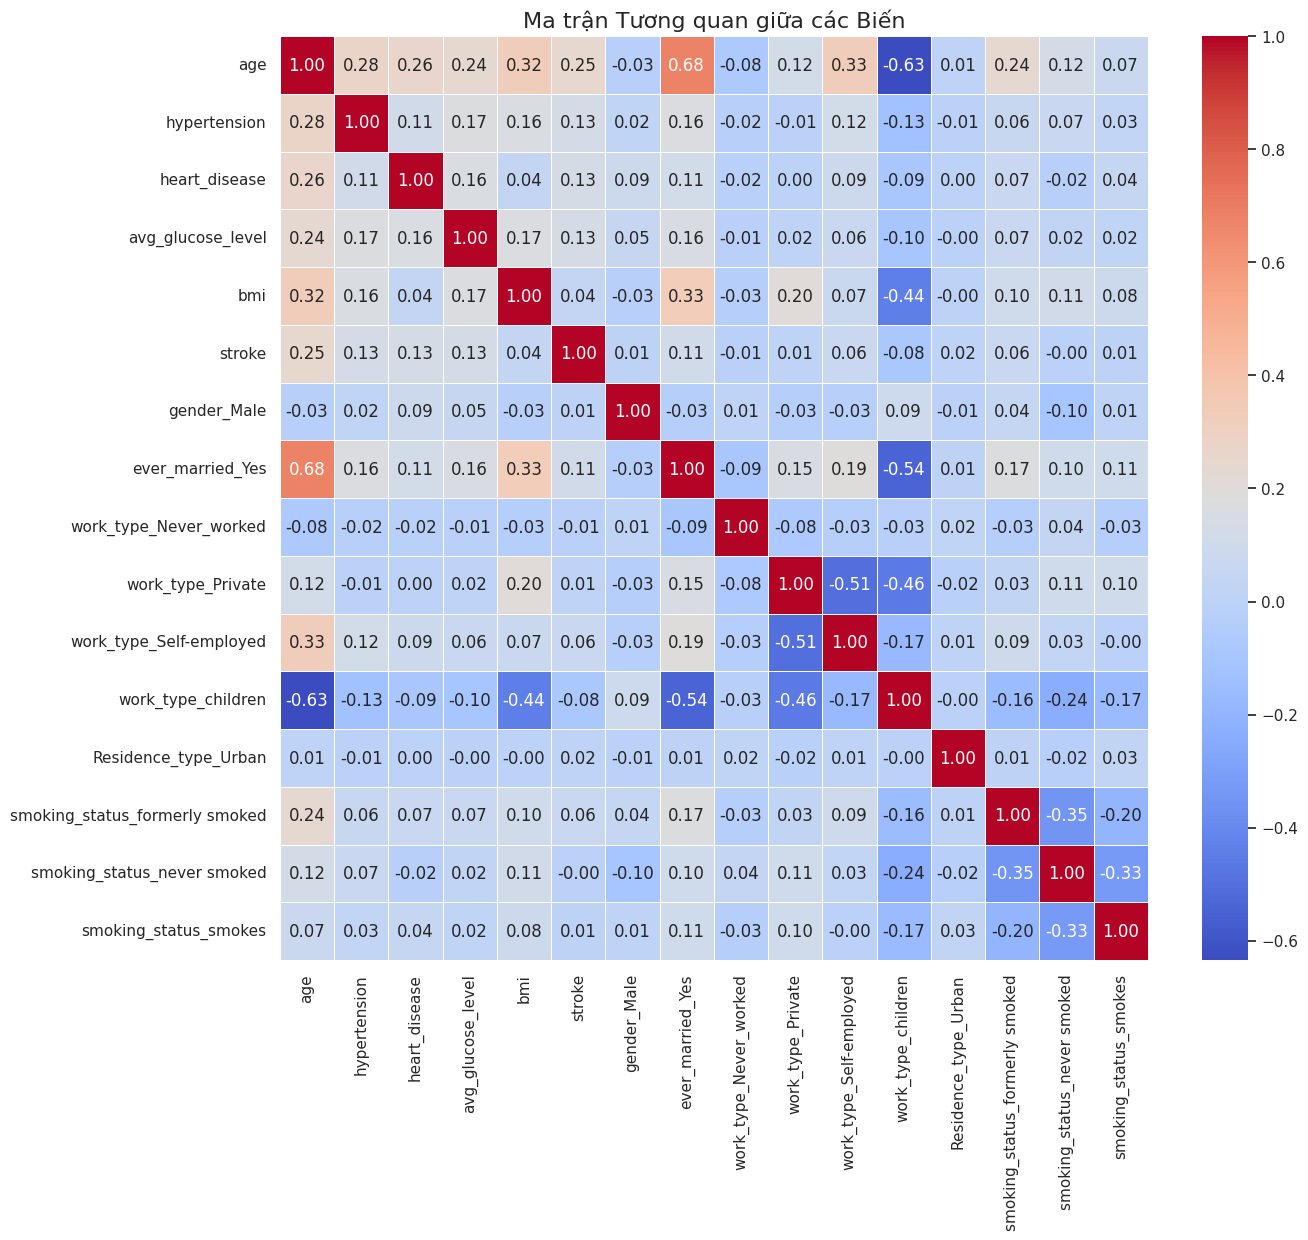

In [107]:
# @title Cell 8: EDA - Ma trận Tương quan
# Vẽ heatmap để xem xét mối tương quan tuyến tính giữa các biến.
plt.figure(figsize=(14, 12))
correlation_matrix = df_encoded.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Ma trận Tương quan giữa các Biến', fontsize=16)
plt.show()

/tmp/ipython-input-4205532493.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(['Không', 'Có'])
/tmp/ipython-input-4205532493.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(['Không', 'Có'])


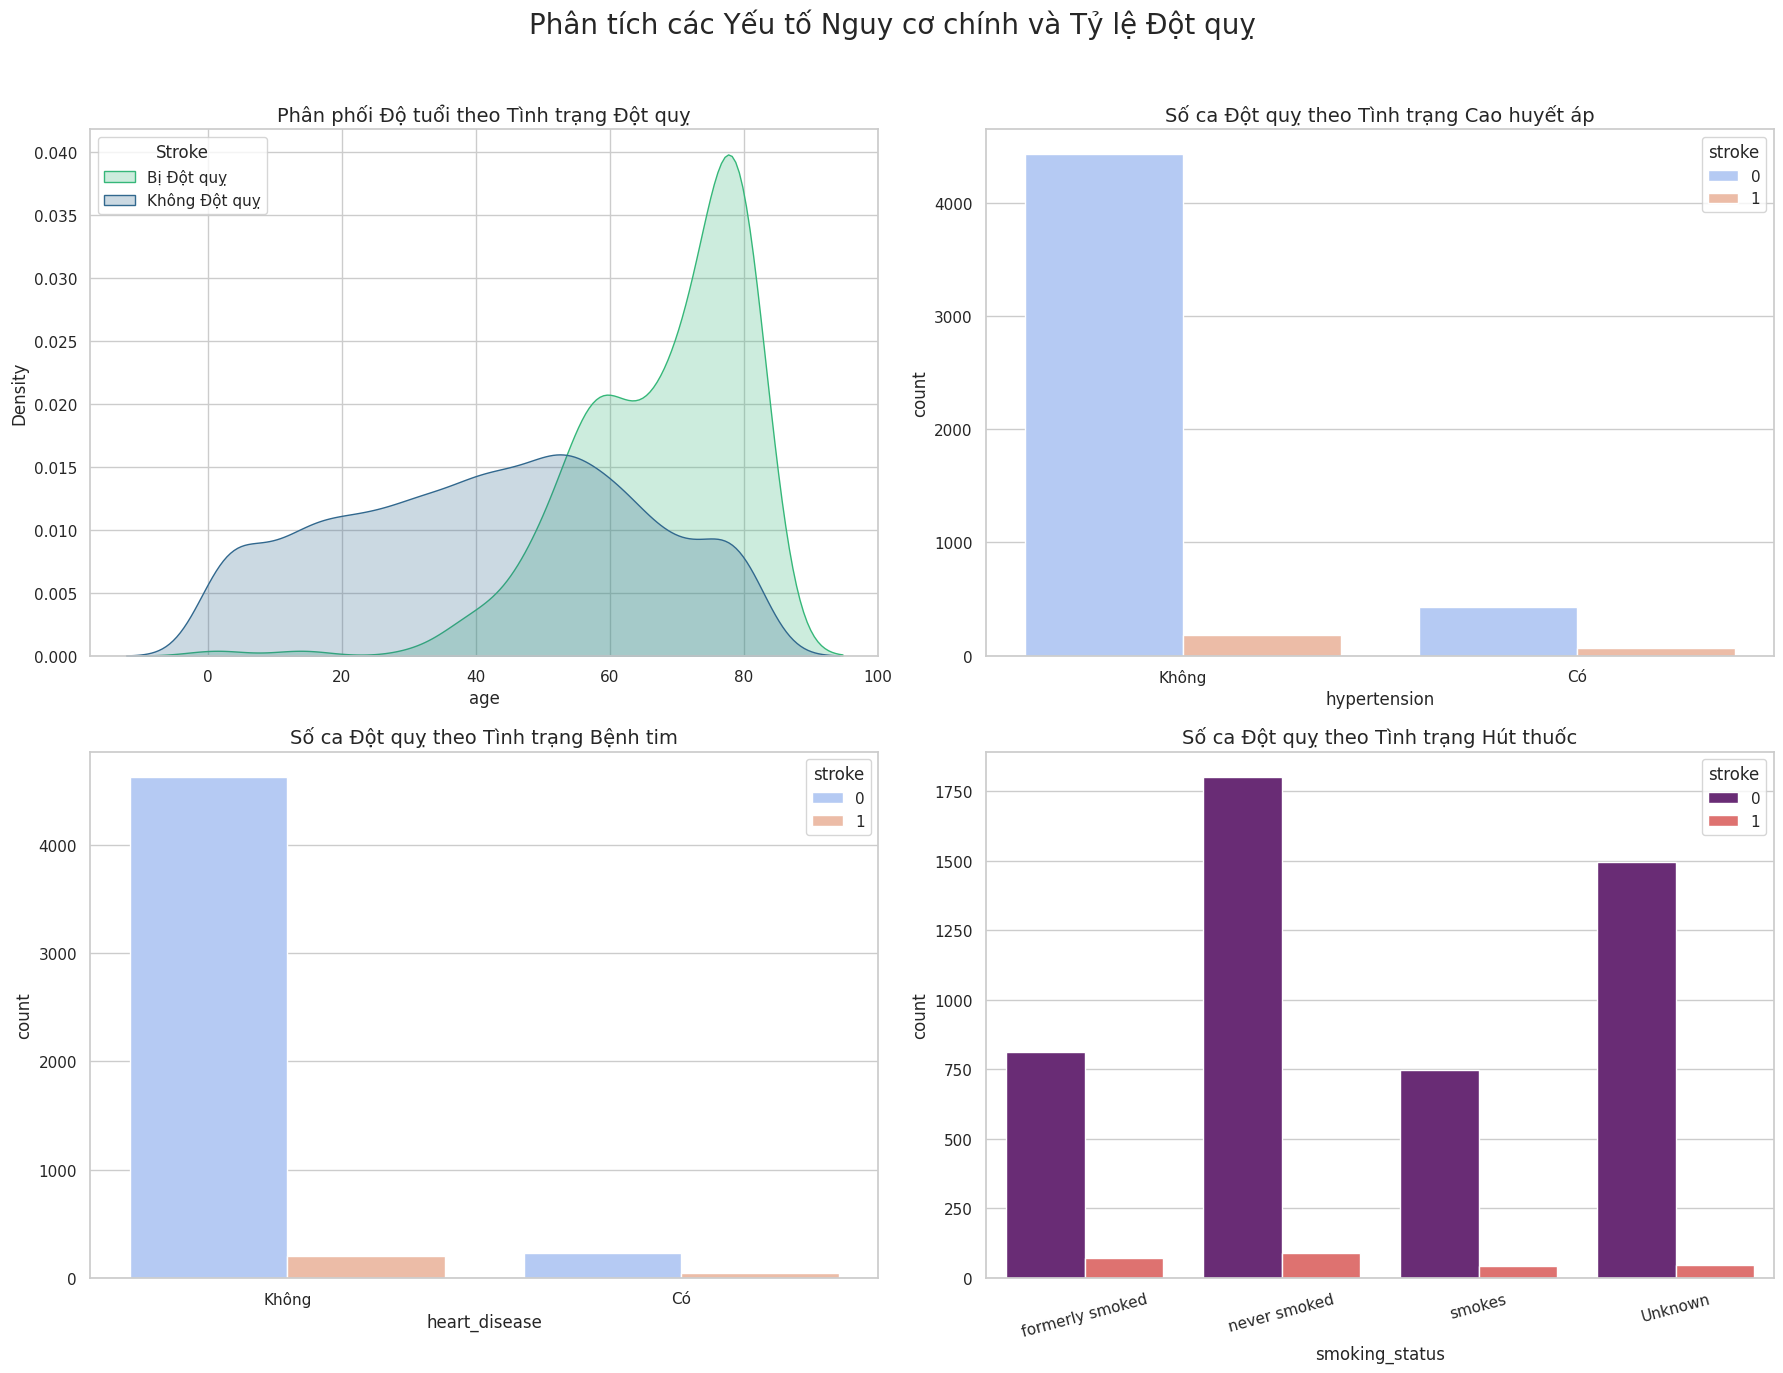


=> Nhận xét: Tuổi càng cao, nguy cơ đột quỵ càng tăng rõ rệt. Có bệnh nền (cao huyết áp, bệnh tim) và tình trạng đã từng hút thuốc cũng làm tăng số ca đột quỵ.


In [108]:
# @title Cell 9: EDA - Phân tích các Yếu tố Nguy cơ
# Tạo các biểu đồ để phân tích mối quan hệ giữa các yếu tố và nguy cơ đột quỵ.
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Phân tích các Yếu tố Nguy cơ chính và Tỷ lệ Đột quỵ', fontsize=20)

# 1. Phân phối Độ tuổi
sns.kdeplot(data=df_encoded, x='age', hue='stroke', fill=True, common_norm=False, palette='viridis', ax=axes[0, 0])
axes[0, 0].set_title('Phân phối Độ tuổi theo Tình trạng Đột quỵ', fontsize=14)
axes[0, 0].legend(title='Stroke', labels=['Bị Đột quỵ', 'Không Đột quỵ'])

# 2. Cao huyết áp
sns.countplot(data=df, x='hypertension', hue='stroke', palette='coolwarm', ax=axes[0, 1])
axes[0, 1].set_title('Số ca Đột quỵ theo Tình trạng Cao huyết áp', fontsize=14)
axes[0, 1].set_xticklabels(['Không', 'Có'])

# 3. Bệnh tim
sns.countplot(data=df, x='heart_disease', hue='stroke', palette='coolwarm', ax=axes[1, 0])
axes[1, 0].set_title('Số ca Đột quỵ theo Tình trạng Bệnh tim', fontsize=14)
axes[1, 0].set_xticklabels(['Không', 'Có'])


# 4. Tình trạng hút thuốc
sns.countplot(data=df, x='smoking_status', hue='stroke', palette='magma', ax=axes[1, 1])
axes[1, 1].set_title('Số ca Đột quỵ theo Tình trạng Hút thuốc', fontsize=14)
axes[1, 1].tick_params(axis='x', rotation=15)


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("\n=> Nhận xét: Tuổi càng cao, nguy cơ đột quỵ càng tăng rõ rệt. Có bệnh nền (cao huyết áp, bệnh tim) và tình trạng đã từng hút thuốc cũng làm tăng số ca đột quỵ.")

In [109]:
# @title Cell 10: Tách Biến và Chia Train/Test
# --- 1. Tách biến độc lập (X) và biến phụ thuộc (y) ---
y = df_encoded['stroke']
X = df_encoded.drop('stroke', axis=1)

# --- 2. Chia dữ liệu thành tập huấn luyện và kiểm tra ---
# Sử dụng stratify=y để đảm bảo tỷ lệ lớp 'stroke' trong tập train và test là tương đương nhau.
# Đây là bước cực kỳ quan trọng với dữ liệu mất cân bằng.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Đã chia dữ liệu thành các tập Huấn luyện và Kiểm tra.")
print(f"Kích thước X_train: {X_train.shape}, Kích thước y_train: {y_train.shape}")
print(f"Kích thước X_test: {X_test.shape}, Kích thước y_test: {y_test.shape}")
print(f"\nTỷ lệ đột quỵ trong y_train: {y_train.value_counts(normalize=True)[1]:.4f}")
print(f"Tỷ lệ đột quỵ trong y_test:  {y_test.value_counts(normalize=True)[1]:.4f}")

Đã chia dữ liệu thành các tập Huấn luyện và Kiểm tra.
Kích thước X_train: (4087, 15), Kích thước y_train: (4087,)
Kích thước X_test: (1022, 15), Kích thước y_test: (1022,)

Tỷ lệ đột quỵ trong y_train: 0.0487
Tỷ lệ đột quỵ trong y_test:  0.0489


In [110]:
# @title Cell 11: Chuẩn hóa Dữ liệu (Feature Scaling)
# Chuẩn hóa các biến số để chúng có cùng thang đo (mean=0, std=1).
# Điều này rất quan trọng đối với các thuật toán nhạy cảm với khoảng cách như SVM, KNN, Logistic Regression.
scaler = StandardScaler()

# FIT và TRANSFORM trên tập train: scaler học các tham số (mean, std) từ tập train và biến đổi nó.
X_train_scaled = scaler.fit_transform(X_train)

# Chỉ TRANSFORM trên tập test: sử dụng các tham số đã học từ tập train để biến đổi tập test.
# Điều này tránh rò rỉ dữ liệu (data leakage) từ tập test vào quá trình huấn luyện.
X_test_scaled = scaler.transform(X_test)

print("Đã chuẩn hóa thành công tập train và test.")

Đã chuẩn hóa thành công tập train và test.


In [111]:
# @title Cell 12: Xử lý Mất cân bằng dữ liệu với SMOTE
# Đây là bước quan trọng nhất để cải thiện mô hình.
# SMOTE (Synthetic Minority Over-sampling Technique) sẽ tạo ra các mẫu dữ liệu tổng hợp cho lớp thiểu số (đột quỵ).
# **LƯU Ý QUAN TRỌNG:** SMOTE chỉ được áp dụng trên TẬP HUẤN LUYỆN (X_train_scaled, y_train).
# Tập kiểm tra (test set) phải được giữ nguyên để phản ánh đúng thực tế dữ liệu.

print(f"Kích thước tập train trước khi SMOTE: {X_train_scaled.shape}")
print(f"Phân phối lớp 'stroke' trước khi SMOTE:\n{y_train.value_counts()}")

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("\n" + "="*50 + "\n")
print("Đã áp dụng SMOTE thành công trên tập train.")
print(f"Kích thước tập train sau khi SMOTE: {X_train_resampled.shape}")
print(f"Phân phối lớp 'stroke' sau khi SMOTE:\n{y_train_resampled.value_counts()}")

Kích thước tập train trước khi SMOTE: (4087, 15)
Phân phối lớp 'stroke' trước khi SMOTE:
stroke
0    3888
1     199
Name: count, dtype: int64


Đã áp dụng SMOTE thành công trên tập train.
Kích thước tập train sau khi SMOTE: (7776, 15)
Phân phối lớp 'stroke' sau khi SMOTE:
stroke
0    3888
1    3888
Name: count, dtype: int64


/tmp/ipython-input-1088773270.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, ax=axes[0], palette='viridis')
/tmp/ipython-input-1088773270.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Không Đột quỵ (0)', 'Đột quỵ (1)'])
/tmp/ipython-input-1088773270.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_resampled, ax=axes[1], palette='viridis')
/tmp/ipython-input-1088773270.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Không Đột quỵ 

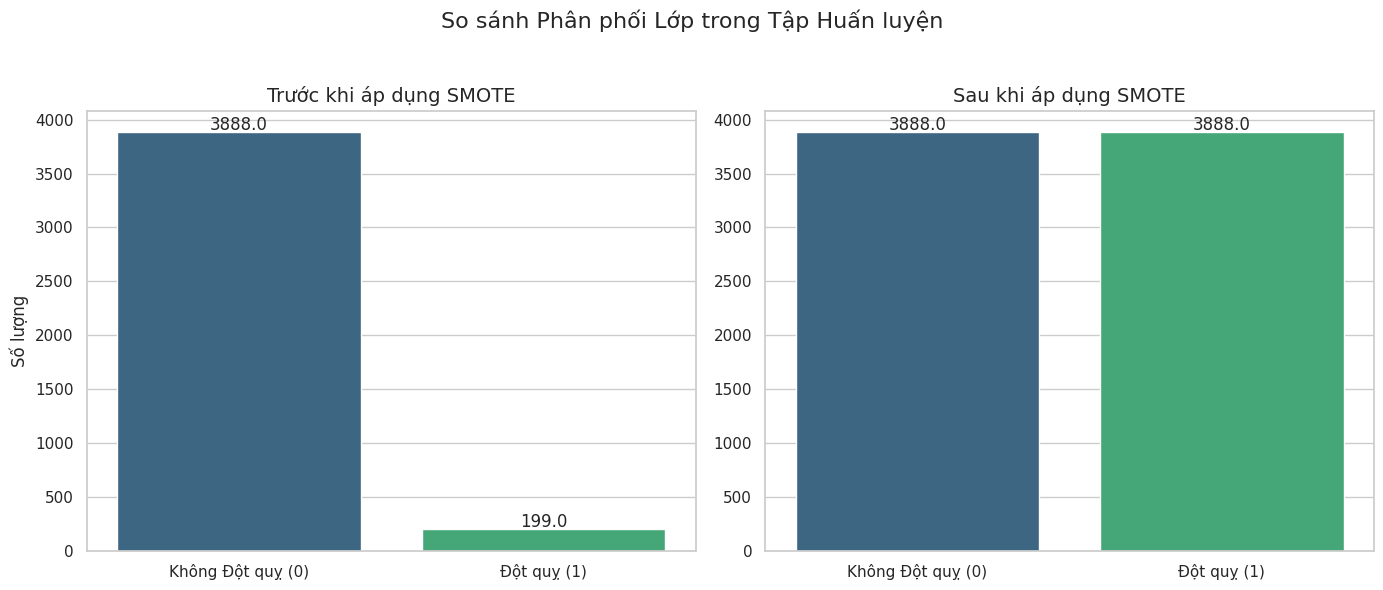


=> Nhận xét: Như bạn có thể thấy, sau khi áp dụng SMOTE, lớp thiểu số 'Đột quỵ (1)' đã được tạo thêm các mẫu tổng hợp để có số lượng bằng với lớp đa số 'Không Đột quỵ (0)'.
   - Tập dữ liệu huấn luyện mới (X_train_resampled, y_train_resampled) giờ đây đã được cân bằng hoàn hảo (tỷ lệ 50/50), giúp mô hình học được các đặc trưng của cả hai lớp một cách công bằng hơn.


In [112]:
# @title Cell 12a: Trực quan hóa Cân bằng Dữ liệu Trước và Sau SMOTE
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('So sánh Phân phối Lớp trong Tập Huấn luyện', fontsize=16)

# Biểu đồ 1: Trước khi SMOTE
sns.countplot(x=y_train, ax=axes[0], palette='viridis')
axes[0].set_title('Trước khi áp dụng SMOTE', fontsize=14)
axes[0].set_xticklabels(['Không Đột quỵ (0)', 'Đột quỵ (1)'])
axes[0].set_xlabel('')
axes[0].set_ylabel('Số lượng', fontsize=12)
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Biểu đồ 2: Sau khi SMOTE
sns.countplot(x=y_train_resampled, ax=axes[1], palette='viridis')
axes[1].set_title('Sau khi áp dụng SMOTE', fontsize=14)
axes[1].set_xticklabels(['Không Đột quỵ (0)', 'Đột quỵ (1)'])
axes[1].set_xlabel('')
axes[1].set_ylabel('') # Ẩn trục y để gọn hơn
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print("\n=> Nhận xét: Như bạn có thể thấy, sau khi áp dụng SMOTE, lớp thiểu số 'Đột quỵ (1)' đã được tạo thêm các mẫu tổng hợp để có số lượng bằng với lớp đa số 'Không Đột quỵ (0)'.")
print("   - Tập dữ liệu huấn luyện mới (X_train_resampled, y_train_resampled) giờ đây đã được cân bằng hoàn hảo (tỷ lệ 50/50), giúp mô hình học được các đặc trưng của cả hai lớp một cách công bằng hơn.")

In [113]:
# @title Cell 13: Huấn luyện các Mô hình Cơ sở (trên dữ liệu đã cân bằng)
# Khởi tạo lại các mô hình
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(random_state=42, probability=True),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Huấn luyện các mô hình trên tập train đã được chuẩn hóa và cân bằng bằng SMOTE
print("=== BẮT ĐẦU HUẤN LUYỆN CÁC MÔ HÌNH CƠ SỞ ===")
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    print(f"Đã huấn luyện xong: {name}")

=== BẮT ĐẦU HUẤN LUYỆN CÁC MÔ HÌNH CƠ SỞ ===
Đã huấn luyện xong: Logistic Regression
Đã huấn luyện xong: K-Nearest Neighbors
Đã huấn luyện xong: Support Vector Machine
Đã huấn luyện xong: Decision Tree
Đã huấn luyện xong: Random Forest


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:31:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Đã huấn luyện xong: XGBoost


In [114]:
# @title Cell 14: Xây dựng Mô hình Kết hợp (Ensemble Voting)
print("\n=== XÂY DỰNG MÔ HÌNH KẾT HỢP ===")

# Chọn ra các mô hình có hiệu suất tốt và đa dạng để kết hợp
estimators = [
    ('Logistic Regression', models['Logistic Regression']),
    ('Random Forest', models['Random Forest']),
    ('XGBoost', models['XGBoost'])
]

# Sử dụng voting='soft' để lấy trung bình xác suất, thường cho kết quả tốt hơn 'hard' voting
voting_model = VotingClassifier(estimators=estimators, voting='soft')

# Huấn luyện mô hình kết hợp trên tập dữ liệu đã cân bằng
voting_model.fit(X_train_resampled, y_train_resampled)
print("Đã huấn luyện xong mô hình Soft Voting Ensemble.")

# Thêm mô hình kết hợp vào danh sách để đánh giá
models["Soft Voting Ensemble"] = voting_model


=== XÂY DỰNG MÔ HÌNH KẾT HỢP ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:31:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Đã huấn luyện xong mô hình Soft Voting Ensemble.


In [115]:
# @title Cell 15: Đánh giá tất cả các Mô hình trên Tập Test (Dữ liệu gốc)
results = []
print("\n=== KẾT QUẢ ĐÁNH GIÁ TRÊN TẬP TEST (DỮ LIỆU GỐC, CHƯA CÂN BẰNG) ===")

# Đánh giá hiệu suất của các mô hình trên tập test gốc (chưa qua SMOTE)
# để xem mô hình tổng quát hóa tốt như thế nào trên dữ liệu thực tế.
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    y_probs = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None

    print(f"\n--- {name} ---")
    # In ra báo cáo phân loại chi tiết
    print(classification_report(y_test, y_pred, zero_division=0))

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_probs) if y_probs is not None else 0
    pr_auc = average_precision_score(y_test, y_probs) if y_probs is not None else 0

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall (Class 1)": report['1']['recall'],
        "Precision (Class 1)": report['1']['precision'],
        "F1-Score (Class 1)": report['1']['f1-score'],
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc
    })


=== KẾT QUẢ ĐÁNH GIÁ TRÊN TẬP TEST (DỮ LIỆU GỐC, CHƯA CÂN BẰNG) ===

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       972
           1       0.13      0.80      0.23        50

    accuracy                           0.74      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.74      0.81      1022


--- K-Nearest Neighbors ---
              precision    recall  f1-score   support

           0       0.97      0.86      0.91       972
           1       0.13      0.42      0.20        50

    accuracy                           0.84      1022
   macro avg       0.55      0.64      0.55      1022
weighted avg       0.93      0.84      0.87      1022


--- Support Vector Machine ---
              precision    recall  f1-score   support

           0       0.97      0.81      0.89       972
           1       0.13      0.54      0.21        50

    accuracy           

In [116]:
# @title Cell 16: Bảng So sánh Hiệu suất Tổng thể
# Tạo DataFrame từ kết quả và sắp xếp theo F1-Score để tìm mô hình tốt nhất cho lớp thiểu số.
results_df = pd.DataFrame(results).sort_values(by="F1-Score (Class 1)", ascending=False).reset_index(drop=True)

print("\nBảng So Sánh Hiệu Suất Các Mô Hình (Sắp xếp theo F1-Score cho lớp 'Đột quỵ')")
display(results_df)
print("\n=> Nhận xét: Sau khi áp dụng SMOTE, chỉ số Recall và F1-Score cho lớp 1 (Đột quỵ) đã được cải thiện đáng kể.")


Bảng So Sánh Hiệu Suất Các Mô Hình (Sắp xếp theo F1-Score cho lớp 'Đột quỵ')


,Model,Accuracy,Recall (Class 1),Precision (Class 1),F1-Score (Class 1),ROC-AUC,PR-AUC
0,Logistic Regression,0.736791,0.80,0.133779,0.229226,0.840638,0.287624
1,Soft Voting Ensemble,0.902153,0.28,0.179487,0.218750,0.808642,0.174870
2,Support Vector Machine,0.799413,0.54,0.129187,0.208494,0.778416,0.153479
3,XGBoost,0.923679,0.20,0.208333,0.204082,0.761132,0.146868
4,K-Nearest Neighbors,0.836595,0.42,0.132075,0.200957,0.688169,0.090130
5,Random Forest,0.918787,0.16,0.163265,0.161616,0.750916,0.133779
6,Decision Tree,0.878669,0.22,0.114583,0.150685,0.566276,0.063369



=> Nhận xét: Sau khi áp dụng SMOTE, chỉ số Recall và F1-Score cho lớp 1 (Đột quỵ) đã được cải thiện đáng kể.


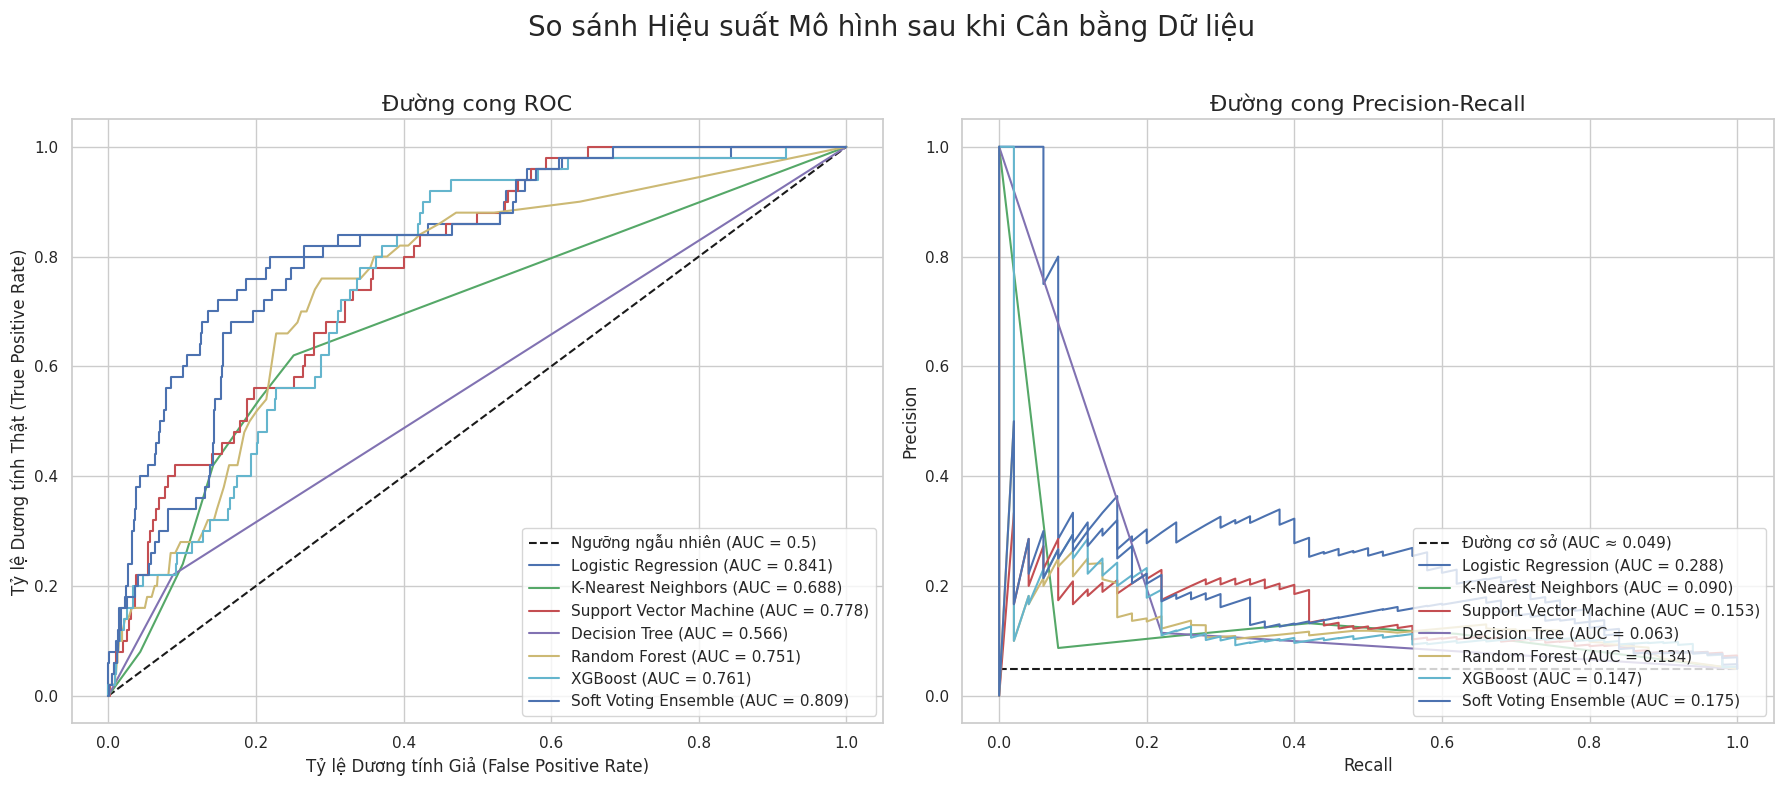

In [117]:
# @title Cell 17: Trực quan hóa Đường cong ROC và Precision-Recall
from sklearn.metrics import roc_curve, precision_recall_curve

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('So sánh Hiệu suất Mô hình sau khi Cân bằng Dữ liệu', fontsize=20)

# --- 1. Vẽ đường cong ROC ---
axes[0].set_title('Đường cong ROC', fontsize=16)
axes[0].plot([0, 1], [0, 1], 'k--', label='Ngưỡng ngẫu nhiên (AUC = 0.5)')

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        roc_auc = results_df.loc[results_df['Model'] == name, 'ROC-AUC'].iloc[0]
        axes[0].plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

axes[0].set_xlabel('Tỷ lệ Dương tính Giả (False Positive Rate)', fontsize=12)
axes[0].set_ylabel('Tỷ lệ Dương tính Thật (True Positive Rate)', fontsize=12)
axes[0].legend(loc='lower right')
axes[0].grid(True)


# --- 2. Vẽ đường cong Precision-Recall ---
axes[1].set_title('Đường cong Precision-Recall', fontsize=16)
no_skill = len(y_test[y_test==1]) / len(y_test)
axes[1].plot([0, 1], [no_skill, no_skill], 'k--', label=f'Đường cơ sở (AUC ≈ {no_skill:.3f})')

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test_scaled)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_probs)
        pr_auc = results_df.loc[results_df['Model'] == name, 'PR-AUC'].iloc[0]
        axes[1].plot(recall, precision, label=f'{name} (AUC = {pr_auc:.3f})')

axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].legend(loc='lower right')
axes[1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

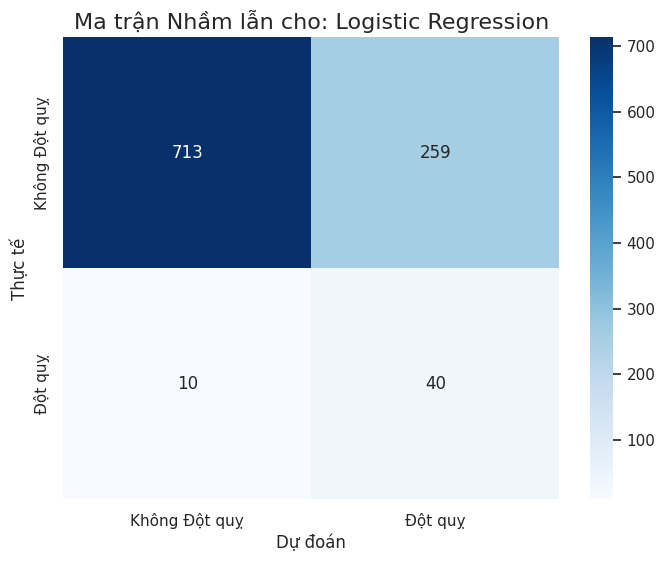


=> Nhận xét: Ma trận nhầm lẫn cho thấy mô hình đã bắt đầu dự đoán đúng các trường hợp đột quỵ (True Positives) thay vì bỏ sót như trước.


In [118]:
# @title Cell 18: Trực quan hóa Ma trận Nhầm lẫn của Mô hình Tốt nhất
# Chọn mô hình tốt nhất dựa trên F1-Score từ bảng kết quả
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Không Đột quỵ', 'Đột quỵ'], yticklabels=['Không Đột quỵ', 'Đột quỵ'])
plt.xlabel('Dự đoán', fontsize=12)
plt.ylabel('Thực tế', fontsize=12)
plt.title(f'Ma trận Nhầm lẫn cho: {best_model_name}', fontsize=16)
plt.show()

print("\n=> Nhận xét: Ma trận nhầm lẫn cho thấy mô hình đã bắt đầu dự đoán đúng các trường hợp đột quỵ (True Positives) thay vì bỏ sót như trước.")

In [119]:
# @title Cell 19: Kết luận và Hướng phát triển
print("=== KẾT LUẬN CUỐI CÙNG VÀ HƯỚNG PHÁT TRIỂN ===")
best_model_name = results_df.iloc[0]['Model']
best_f1_score = results_df.iloc[0]['F1-Score (Class 1)']
best_recall_score = results_df.iloc[0]['Recall (Class 1)']

print(f"\n🏆 MÔ HÌNH TỐT NHẤT (dựa trên F1-score): {best_model_name}")
print(f"   - Điểm F1-Score trên tập Test (Lớp Đột quỵ): {best_f1_score:.4f}")
print(f"   - Điểm Recall trên tập Test (Lớp Đột quỵ): {best_recall_score:.4f}")

print("\n🎯 KẾT LUẬN:")
print("   - Việc áp dụng kỹ thuật SMOTE để xử lý mất cân bằng dữ liệu đã chứng tỏ hiệu quả vượt trội.")
print(f"   - Các mô hình, đặc biệt là {best_model_name}, đã cải thiện đáng kể khả năng phát hiện các trường hợp thực sự bị đột quỵ (Recall tăng cao), đây là mục tiêu quan trọng nhất của bài toán y tế này.")
print("   - Mô hình Soft Voting Ensemble, kết hợp sức mạnh của nhiều mô hình, cũng cho thấy hiệu suất ROC-AUC và PR-AUC rất cạnh tranh, thể hiện sự ổn định và khả năng tổng quát hóa tốt.")
print("   - Dự án đã thành công trong việc xây dựng được một mô hình baseline có ý nghĩa thực tiễn, làm nền tảng cho các cải tiến sâu hơn.")

print("\n🚀 HƯỚNG PHÁT TRIỂN TIẾP THEO:")
print("   1. Tinh chỉnh Siêu tham số (Hyperparameter Tuning): Sử dụng GridSearchCV hoặc RandomizedSearchCV để tìm ra bộ tham số tối ưu cho các mô hình mạnh nhất (ví dụ: XGBoost, Random Forest).")
print("   2. Sử dụng Kỹ thuật Cross-Validation: Đánh giá mô hình một cách đáng tin cậy hơn bằng cách sử dụng K-Fold Cross-Validation trong suốt quá trình huấn luyện và tinh chỉnh.")
print("   3. Khám phá các Kỹ thuật Ensemble Nâng cao: Thử nghiệm với các phương pháp như Stacking hoặc Blending để kết hợp các mô hình một cách thông minh hơn.")
print("   4. Kỹ thuật Feature Engineering: Tạo ra các đặc trưng mới (ví dụ: tương tác giữa tuổi và BMI, phân loại mức độ đường huyết) để cung cấp thêm thông tin cho mô hình.")
print("   5. Triển khai Mô hình (Deployment): Đóng gói mô hình tốt nhất thành một ứng dụng web hoặc API đơn giản để người dùng có thể nhập thông tin và nhận dự đoán.")

=== KẾT LUẬN CUỐI CÙNG VÀ HƯỚNG PHÁT TRIỂN ===

🏆 MÔ HÌNH TỐT NHẤT (dựa trên F1-score): Logistic Regression
   - Điểm F1-Score trên tập Test (Lớp Đột quỵ): 0.2292
   - Điểm Recall trên tập Test (Lớp Đột quỵ): 0.8000

🎯 KẾT LUẬN:
   - Việc áp dụng kỹ thuật SMOTE để xử lý mất cân bằng dữ liệu đã chứng tỏ hiệu quả vượt trội.
   - Các mô hình, đặc biệt là Logistic Regression, đã cải thiện đáng kể khả năng phát hiện các trường hợp thực sự bị đột quỵ (Recall tăng cao), đây là mục tiêu quan trọng nhất của bài toán y tế này.
   - Mô hình Soft Voting Ensemble, kết hợp sức mạnh của nhiều mô hình, cũng cho thấy hiệu suất ROC-AUC và PR-AUC rất cạnh tranh, thể hiện sự ổn định và khả năng tổng quát hóa tốt.
   - Dự án đã thành công trong việc xây dựng được một mô hình baseline có ý nghĩa thực tiễn, làm nền tảng cho các cải tiến sâu hơn.

🚀 HƯỚNG PHÁT TRIỂN TIẾP THEO:
   1. Tinh chỉnh Siêu tham số (Hyperparameter Tuning): Sử dụng GridSearchCV hoặc RandomizedSearchCV để tìm ra bộ tham số tối ưu cho cá